## 1. Environment Setup and Imports

In [1]:
import sys
import os
import time
from typing import Dict, List, Optional, Tuple

import jax
import jax.numpy as jnp
import jax.random as jar
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Add MalthusJAX to path
sys.path.append('/Users/leonardodicaterina/Documents/GitHub/MalthusJAX/src')

# Import MalthusJAX core components
from malthusjax.core.genome.binary import BinaryGenome
from malthusjax.core.genome.real import RealGenome
from malthusjax.core.fitness.binary_ones import BinarySumFitnessEvaluator, KnapsackFitnessEvaluator
from malthusjax.core.fitness.real import RastriginFitnessEvaluator
from malthusjax.operators.selection.tournament import TournamentSelection
from malthusjax.operators.crossover.binary import UniformCrossover as BinaryUniformCrossover
from malthusjax.operators.crossover.real import UniformCrossover as RealUniformCrossover
from malthusjax.operators.mutation.binary import BitFlipMutation
from malthusjax.operators.mutation.real import BallMutation
from malthusjax.engine.basic_engine import GeneticEngineParams, GeneticEngine

# Import the NEW Level 4 Visualization Module
from malthusjax.visualization import (
    EvolutionVisualizer,
    GeneticAlgorithmVisualizer, 
    EngineComparator,
    FunctionalDataAnalyzer,
    VisualizationConfig
)


# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('default')  # Reset to default before applying Level 4 styling

## 2. Level 4 Configuration Setup

Demonstrate the new configuration-driven approach with `VisualizationConfig`.

In [2]:
# Configure Level 4 visualization styling
level4_config = VisualizationConfig(
    figsize=(14, 9),
    style='seaborn-v0_8',
    color_palette='husl',
    dpi=100,
    save_format='png'
)

print("📊 Level 4 Visualization Configuration:")
print(f"   Figure size: {level4_config.figsize}")
print(f"   Style: {level4_config.style}")
print(f"   Color palette: {level4_config.color_palette}")
print(f"   DPI: {level4_config.dpi}")
print(f"   Save format: {level4_config.save_format}")

# Alternative configuration for comparison
alternative_config = VisualizationConfig(
    figsize=(12, 8),
    style='default',
    color_palette='viridis',
    dpi=150
)

print("\n🎨 Alternative Configuration Available for Comparison")

📊 Level 4 Visualization Configuration:
   Figure size: (14, 9)
   Style: seaborn-v0_8
   Color palette: husl
   DPI: 100
   Save format: png

🎨 Alternative Configuration Available for Comparison


## 3. Generate Evolution Data

Create sample evolution runs to demonstrate Level 4 visualization capabilities.

In [3]:
# Configure genetic algorithm
engine_params = GeneticEngineParams(
    pop_size=500,
    elitism=3,
    num_generations=500,
)

KnapsackFitnessEvaluator_instance = KnapsackFitnessEvaluator(
    weights=jar.uniform(jar.PRNGKey(0), (1000,), minval=1, maxval=10),
    values=jar.uniform(jar.PRNGKey(1), (1000,), minval=10, maxval=100),
    weight_limit=2500
)

# Create genetic algorithm engine
engine = GeneticEngine(
    genome_representation=BinaryGenome(array_shape=(1000,), p=0.01),
    fitness_evaluator=KnapsackFitnessEvaluator_instance, #BinarySumFitnessEvaluator(),
    selection_operator=TournamentSelection(number_of_choices=497, tournament_size=3),
    crossover_operator=BinaryUniformCrossover(crossover_rate=0.8, n_outputs=1),
    mutation_operator=BitFlipMutation(mutation_rate=0.02)
)

'''engine = GeneticEngine(
    genome_representation = RealGenome(array_shape=(1000,), min_val=-5.12, max_val=5.12, random_key=jar.PRNGKey(42)),
    fitness_evaluator=RastriginFitnessEvaluator(),
    selection_operator=TournamentSelection(number_of_choices=497, tournament_size=3),
    crossover_operator=RealUniformCrossover(crossover_rate=0.8, n_outputs=1),
    mutation_operator=BallMutation(mutation_rate=0.02)
)
'''
print("🧬 Genetic Algorithm Configuration:")
print(f"   Problem: Maximize sum of {1000} binary genes")
print(f"   Population size: {engine_params.pop_size}")
print(f"   Generations: {engine_params.num_generations}")
print(f"   Elitism: {engine_params.elitism}")

# Pre-compile for efficiency
print("\n⚡ Pre-compiling evolution function...")
engine.compile_evolution(engine_params)
print("   ✅ Compilation complete and cached!")

🧬 Genetic Algorithm Configuration:
   Problem: Maximize sum of 1000 binary genes
   Population size: 500
   Generations: 500
   Elitism: 3

⚡ Pre-compiling evolution function...
   ✅ Compilation complete and cached!


In [4]:
# Test genome initialization
genome_init_fn = BinaryGenome(array_shape=(1000,), p=0.01).get_random_initialization_pure()
genome_init_fn_jit = jax.jit(genome_init_fn)

# Get the HLO representation - correct way for newer JAX versions
lowered = genome_init_fn_jit.lower(jar.PRNGKey(0))
compiled = lowered.compile()
jaxpr = compiled.as_text()

print("HLO representation (first 500 chars):")
print(jaxpr)

# now get the initialized population from the compiled function
population_genomes = compiled(jar.PRNGKey(10))  # Population size of 100



HLO representation (first 500 chars):
HloModule jit_init_fn, is_scheduled=true, entry_computation_layout={(u32[2]{0})->pred[1000]{0}}, allow_spmd_sharding_propagation_to_parameters={true}, allow_spmd_sharding_propagation_to_output={true}

%fused_computation (param_0.2: u32[], param_1.5: u32[4], param_2.6: u32[1000], param_3.7: u32[1000], param_4.12: s32[]) -> u32[1000] {
  %param_3.7 = u32[1000]{0} parameter(3)
  %param_2.6 = u32[1000]{0} parameter(2)
  %add.103 = u32[1000]{0} add(%param_3.7, %param_2.6), metadata={op_name="jit(init_fn)/jit(_bernoulli)/jit(_uniform)/while/body/closed_call/add" source_file="/var/folders/n8/08b2nd114jdfnsydb_4mj4fw0000gn/T/ipykernel_80724/4045345905.py" source_line=9 source_end_line=9 source_column=12 source_end_column=69}
  %param_1.5 = u32[4]{0} parameter(1)
  %slice.29 = u32[1]{0} slice(%param_1.5), slice={[0:1]}, metadata={op_name="jit(init_fn)/jit(_bernoulli)/jit(_uniform)/while/body/closed_call/slice" source_file="/var/folders/n8/08b2nd114jdfnsydb_

## 4. Single Run Evolution

Generate a single evolution run for Level 4 single-run visualization demos.

In [5]:
# Execute single evolution run
print("🔬 Executing single evolution run...")
print("   Using pre-compiled evolution function (cached from above)")
rng = jar.PRNGKey(42)
initial_state = engine.init_state(rng, engine_params)

# Note: compile=True here uses the cached compilation from engine.compile_evolution()
# No recompilation occurs - the engine uses its cached compiled function
final_state, history, elapsed_time = engine.run(
    initial_state, engine_params, time_it=True, compile=True, verbose=False
)

print(f"   ✅ Evolution complete in {elapsed_time:.2f} seconds")
print(f"   Initial fitness: {initial_state.best_fitness:.2f}")
print(f"   Final fitness: {final_state.best_fitness:.2f}")
print(f"   Improvement: {final_state.best_fitness - initial_state.best_fitness:.2f}")
print(f"   Generations: {final_state.generation}")

# Show available KPIs in the history
available_kpis = list(history.__dataclass_fields__.keys())
print(f"\n📊 Available KPIs in evolution history: {len(available_kpis)}")
for i, kpi in enumerate(available_kpis):
    if kpi not in ['best_genome', 'generation']:  # Skip non-plottable fields
        print(f"   {i+1}. {kpi}")

print(f"\n💡 Key Point: The engine.run() call above used the cached compiled function")
print(f"   No recompilation occurred - demonstrating MalthusJAX's compilation caching!")

🔬 Executing single evolution run...
   Using pre-compiled evolution function (cached from above)
   ✅ Evolution complete in 1.28 seconds
   Initial fitness: 1181.64
   Final fitness: 31524.78
   Improvement: 30343.14
   Generations: 500

📊 Available KPIs in evolution history: 7
   1. best_fitness
   2. mean_fitness
   4. std_fitness
   5. min_fitness
   7. ema_delta_fitness

💡 Key Point: The engine.run() call above used the cached compiled function
   No recompilation occurred - demonstrating MalthusJAX's compilation caching!


## 5. 🎯 Level 4 Single-Run Visualization Demo

**Stateful Classes with Clean API**

Compare the old static method approach vs. new Level 4 stateful classes.

🚀 LEVEL 4 SINGLE-RUN VISUALIZATION DEMO
❌ OLD WAY - Static Methods (repeated data passing):
   # fig1 = EvolutionVisualizer.create_kpi_dashboard(history, title='A')
   # fig2 = EvolutionVisualizer.create_kpi_dashboard(history, title='B')  # Recomputes!
   # fig3 = GeneticAlgorithmVisualizer.create_convergence_analysis(history)  # Recomputes!

✅ NEW WAY - Level 4 Stateful Classes:
   ✅ EvolutionVisualizer initialized with 5 KPIs
   ✅ GeneticAlgorithmVisualizer initialized for 500 generations
   📊 Available KPIs: best_fitness, mean_fitness, std_fitness, min_fitness, ema_delta_fitness

⚡ Performance Comparison - Caching Benefits:


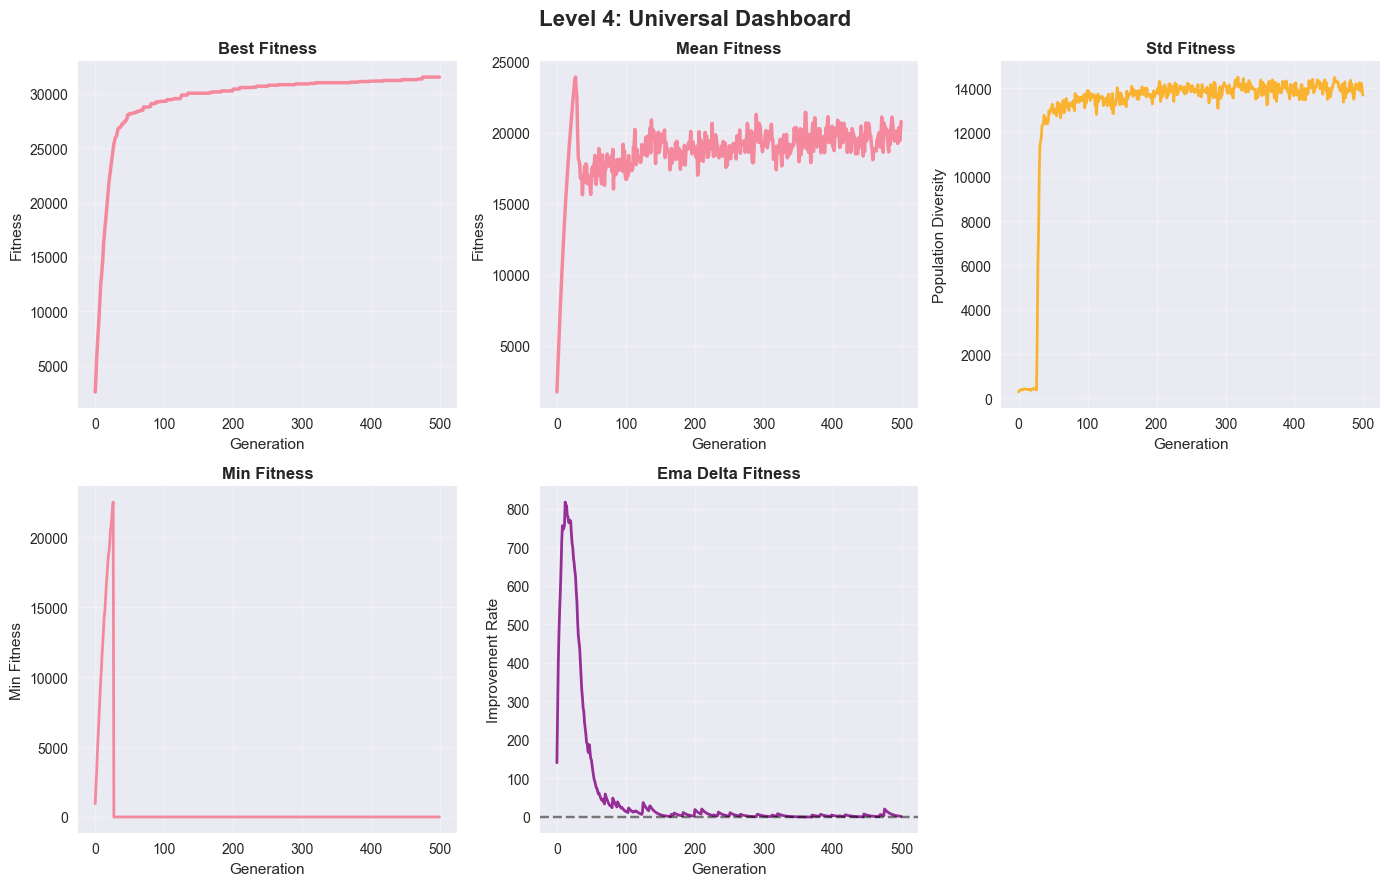

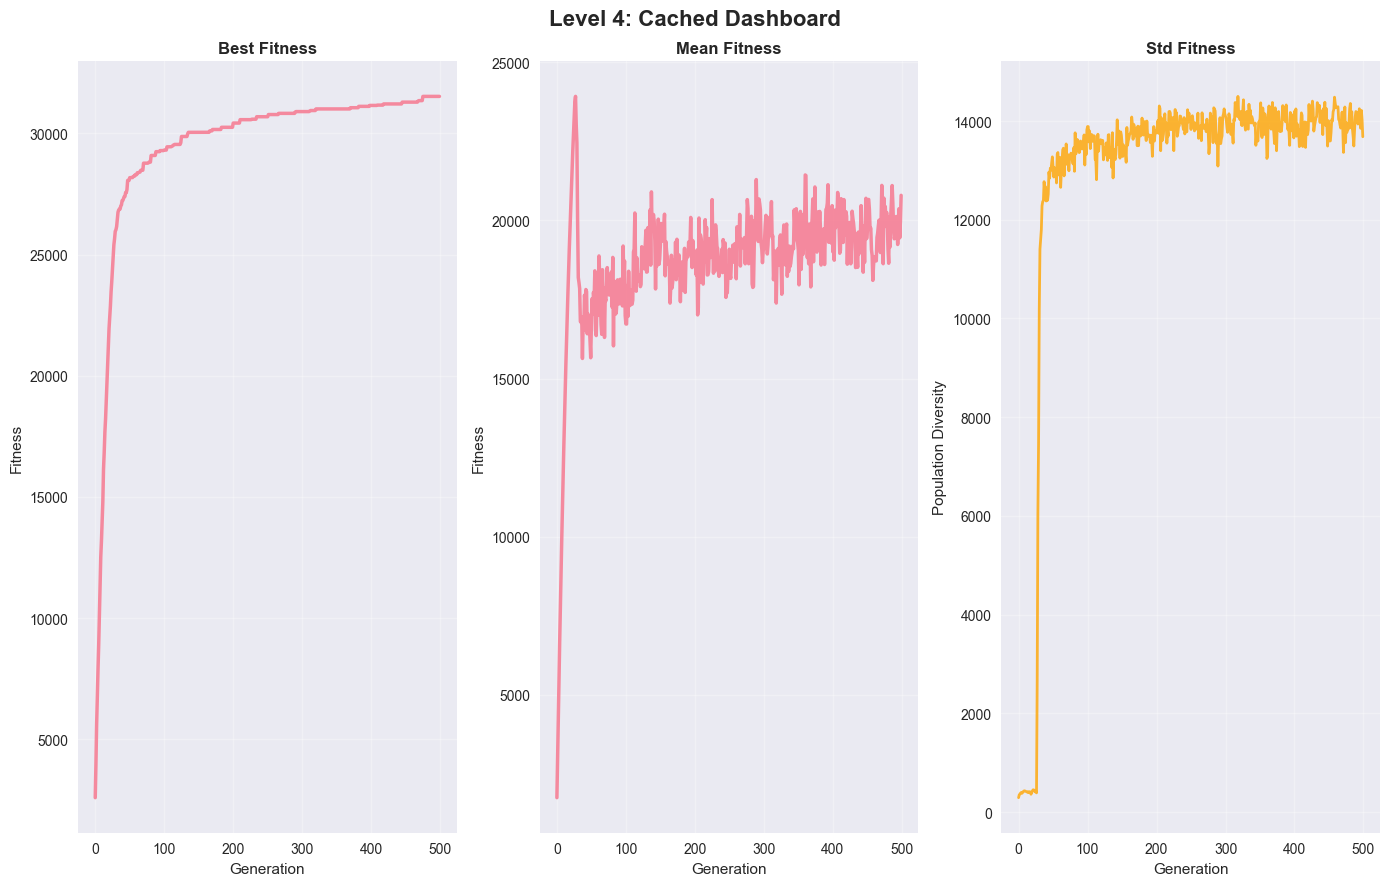

   First dashboard creation: 0.0704 seconds (compute + cache)
   Second dashboard creation: 0.0355 seconds (cache hit)
   Speedup factor: 2.0x faster!


In [6]:
print("🚀 LEVEL 4 SINGLE-RUN VISUALIZATION DEMO")
print("=" * 50)

# OLD WAY (commented out - would be static methods)
print("❌ OLD WAY - Static Methods (repeated data passing):")
print("   # fig1 = EvolutionVisualizer.create_kpi_dashboard(history, title='A')")
print("   # fig2 = EvolutionVisualizer.create_kpi_dashboard(history, title='B')  # Recomputes!")
print("   # fig3 = GeneticAlgorithmVisualizer.create_convergence_analysis(history)  # Recomputes!")

print("\n✅ NEW WAY - Level 4 Stateful Classes:")

# Initialize Level 4 visualizers ONCE with history data
universal_viz = EvolutionVisualizer(history, config=level4_config)
ga_viz = GeneticAlgorithmVisualizer(history, config=level4_config)

print(f"   ✅ EvolutionVisualizer initialized with {len(universal_viz.available_kpis)} KPIs")
print(f"   ✅ GeneticAlgorithmVisualizer initialized for {len(ga_viz.generations)} generations")
print(f"   📊 Available KPIs: {', '.join(universal_viz.available_kpis)}")

print("\n⚡ Performance Comparison - Caching Benefits:")

# First call - computes and caches
start_time = time.time()
dashboard1 = universal_viz.create_dashboard(title="Level 4: Universal Dashboard")
first_call_time = time.time() - start_time

plt.show()

# Second call with different title - uses cache
start_time = time.time() 
dashboard2 = universal_viz.create_dashboard(
    kpis=['best_fitness', 'mean_fitness', 'std_fitness'],
    title="Level 4: Cached Dashboard"
)
second_call_time = time.time() - start_time

plt.show()

print(f"   First dashboard creation: {first_call_time:.4f} seconds (compute + cache)")
print(f"   Second dashboard creation: {second_call_time:.4f} seconds (cache hit)")
print(f"   Speedup factor: {first_call_time/max(second_call_time, 0.0001):.1f}x faster!")

## 6. GA-Specific Visualizations

Demonstrate specialized genetic algorithm visualizations with genome evolution.

🧬 GA-Specific Level 4 Visualizations
----------------------------------------
📊 Creating GA dashboard with genome evolution...


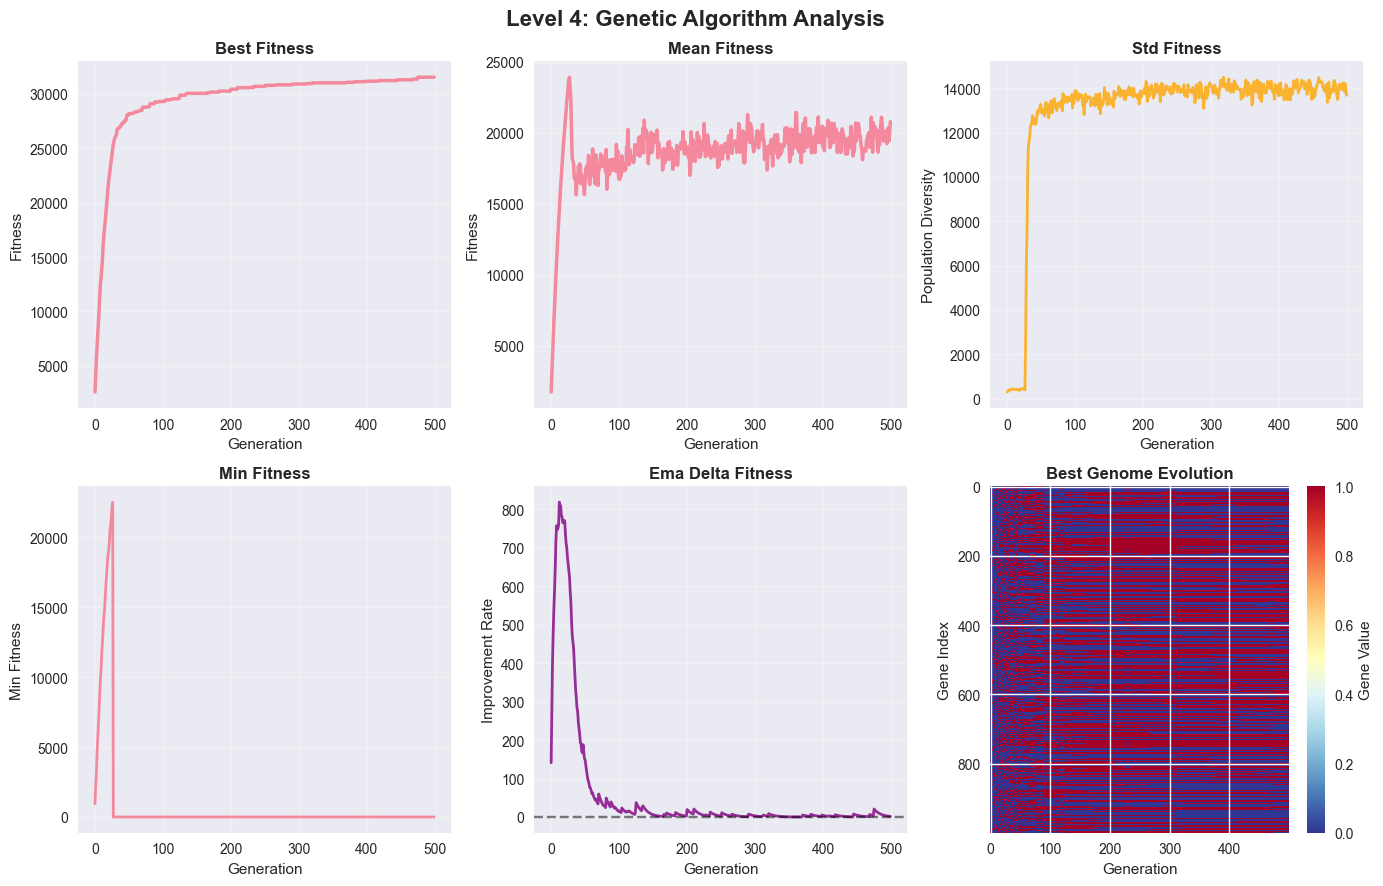

📈 Creating detailed convergence analysis...


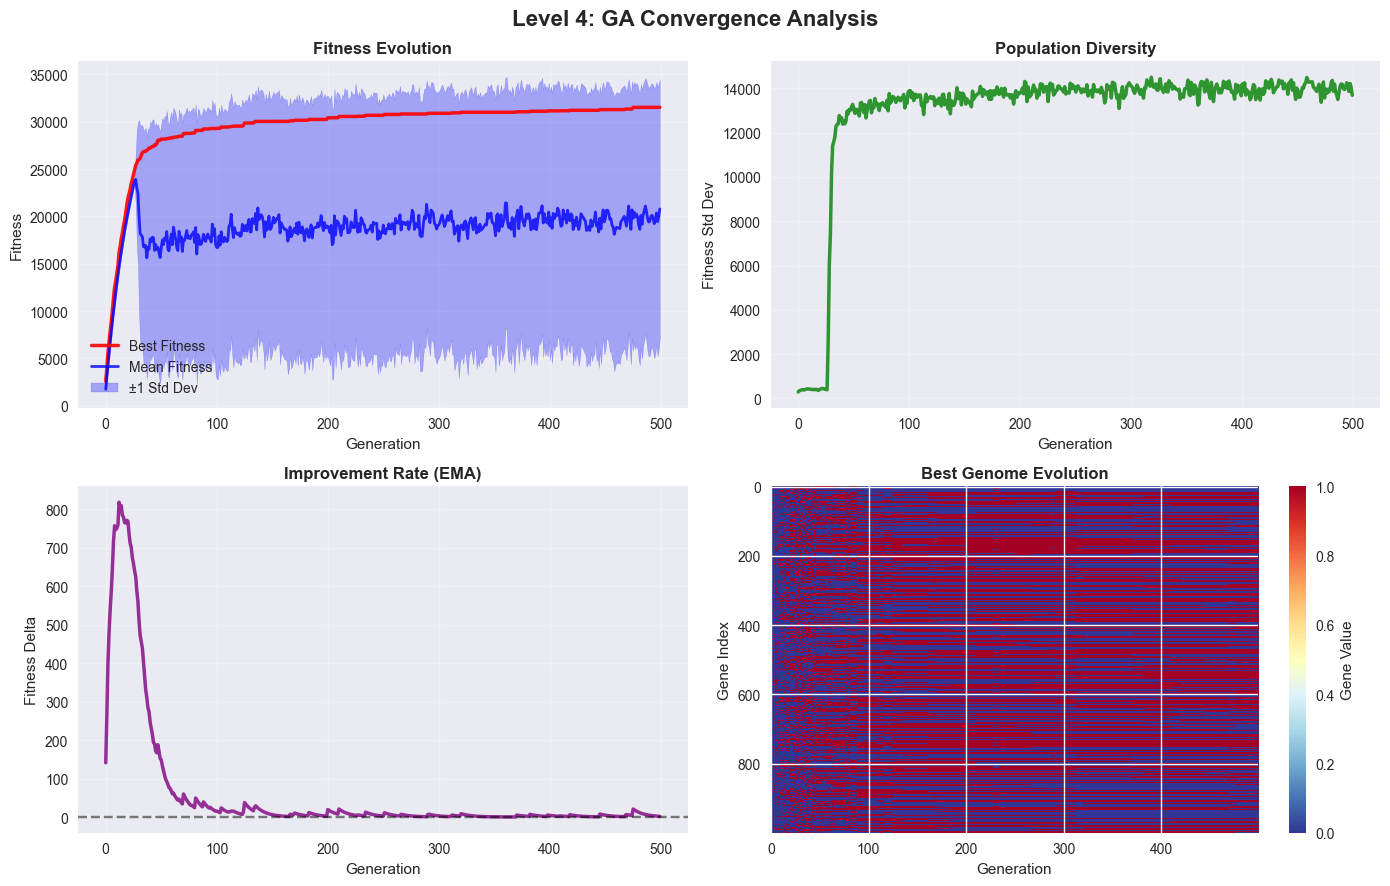

📊 Creating individual KPI plots...


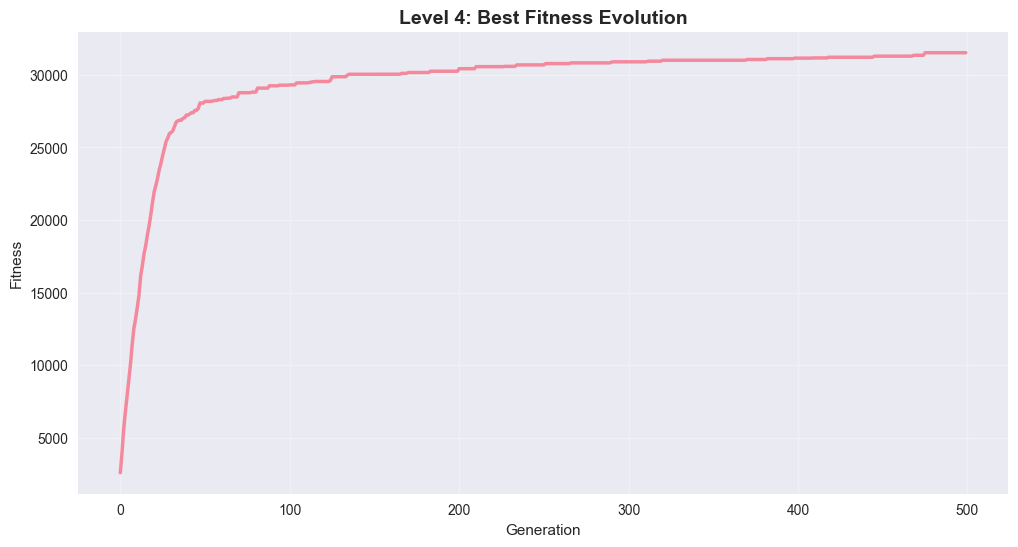

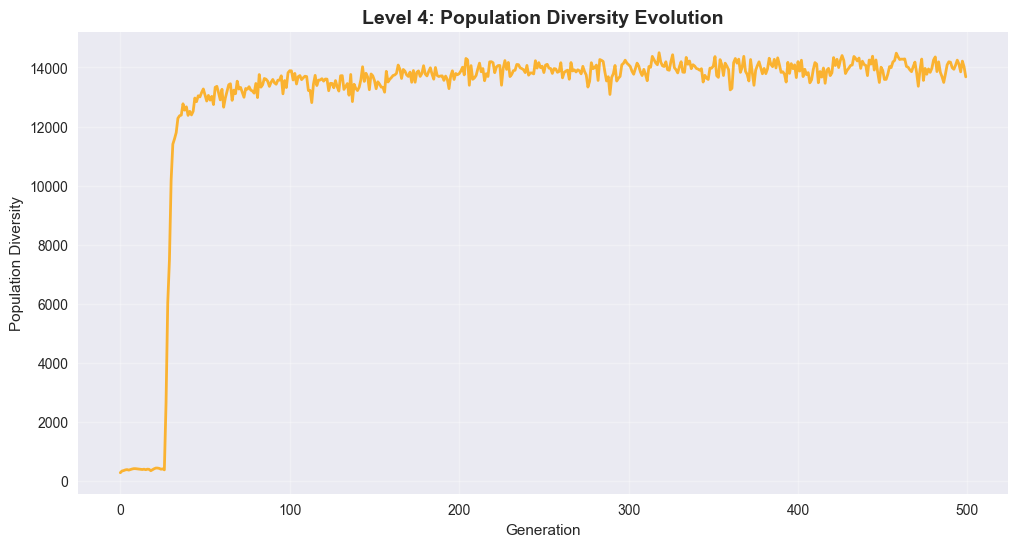

🧬 Creating genome evolution visualization...


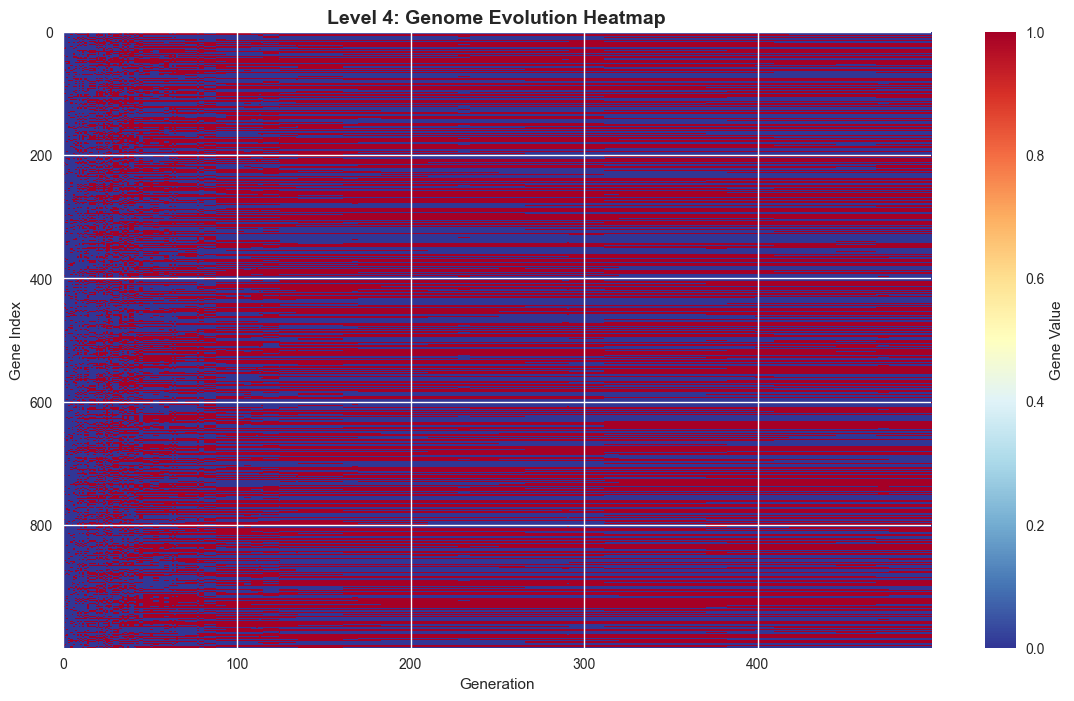


💾 Current cache status:
   Universal visualizer cache: 9 items
   GA visualizer cache: 8 items


In [7]:
print("🧬 GA-Specific Level 4 Visualizations")
print("-" * 40)

# GA-specific dashboard with genome visualization
print("📊 Creating GA dashboard with genome evolution...")
ga_dashboard = ga_viz.create_dashboard(
    include_genome=True,
    title="Level 4: Genetic Algorithm Analysis"
)
plt.show()

# Detailed convergence analysis
print("📈 Creating detailed convergence analysis...")
convergence_analysis = ga_viz.create_convergence_analysis(
    title="Level 4: GA Convergence Analysis"
)
plt.show()

# Individual KPI plots with clean API
print("📊 Creating individual KPI plots...")

# Best fitness evolution
fitness_plot = universal_viz.plot_kpi_evolution(
    'best_fitness',
    title="Level 4: Best Fitness Evolution",
    figsize=(12, 6)
)
plt.show()

# Population diversity if available
if 'std_fitness' in universal_viz.available_kpis:
    diversity_plot = universal_viz.plot_kpi_evolution(
        'std_fitness',
        title="Level 4: Population Diversity Evolution",
        figsize=(12, 6)
    )
    plt.show()

# Genome evolution standalone
print("🧬 Creating genome evolution visualization...")
genome_plot = ga_viz.plot_genome_evolution(
    title="Level 4: Genome Evolution Heatmap",
    figsize=(14, 8)
)
plt.show()

print(f"\n💾 Current cache status:")
print(f"   Universal visualizer cache: {len(universal_viz._cache)} items")
print(f"   GA visualizer cache: {len(ga_viz._cache)} items")

## 7. Multiple Evolution Runs

Generate multiple runs to demonstrate Level 4 multi-run analysis capabilities.

In [8]:
print("🔬 Generating multiple evolution runs for Level 4 multi-run analysis...")

# Generate multiple runs with different random seeds
results = {}
seeds = [1234, 5678, 9101, 1121, 3141, 1617, 1819, 2021, 2223, 2425]

print(f"   Running {len(seeds)} evolution experiments...")

for i, seed in enumerate(seeds):
    rng = jar.PRNGKey(seed)
    initial_state = engine.init_state(rng, engine_params)
    
    # All runs use cached compiled function - no recompilation!
    final_state, run_history, run_time = engine.run(
        initial_state, engine_params, time_it=True, compile=True
    )
    
    results[f'Run {i+1} (seed={seed})'] = run_history
    
    if i % 3 == 0:  # Progress update every 3 runs
        print(f"   ✅ Completed {i+1}/{len(seeds)} runs")

print(f"\n✅ All {len(results)} evolution runs complete!")
print(f"   Ready for Level 4 multi-run analysis")

# Quick performance summary
final_fitnesses = [float(hist.best_fitness[-1]) for hist in results.values()]
print(f"\n📊 Quick Performance Summary:")
print(f"   Best run: {max(final_fitnesses):.2f}")
print(f"   Worst run: {min(final_fitnesses):.2f}")
print(f"   Mean: {np.mean(final_fitnesses):.2f} ± {np.std(final_fitnesses):.2f}")

🔬 Generating multiple evolution runs for Level 4 multi-run analysis...
   Running 10 evolution experiments...
   ✅ Completed 1/10 runs
   ✅ Completed 4/10 runs
   ✅ Completed 7/10 runs
   ✅ Completed 10/10 runs

✅ All 10 evolution runs complete!
   Ready for Level 4 multi-run analysis

📊 Quick Performance Summary:
   Best run: 32106.15
   Worst run: 31340.74
   Mean: 31666.77 ± 247.75


## 8. 🎯 Level 4 Multi-Run Analysis Demo

**Stateful Multi-Run Comparison with Advanced Analytics**

🚀 LEVEL 4 MULTI-RUN ANALYSIS DEMO
✅ NEW WAY - Level 4 Stateful Multi-Run Classes:
   ✅ EngineComparator initialized with 10 runs
   ✅ FunctionalDataAnalyzer initialized for advanced FDA
   📊 Run names: Run 1 (seed=1234), Run 2 (seed=5678), Run 3 (seed=9101)...

📊 Multi-Run Comparison with Statistics:


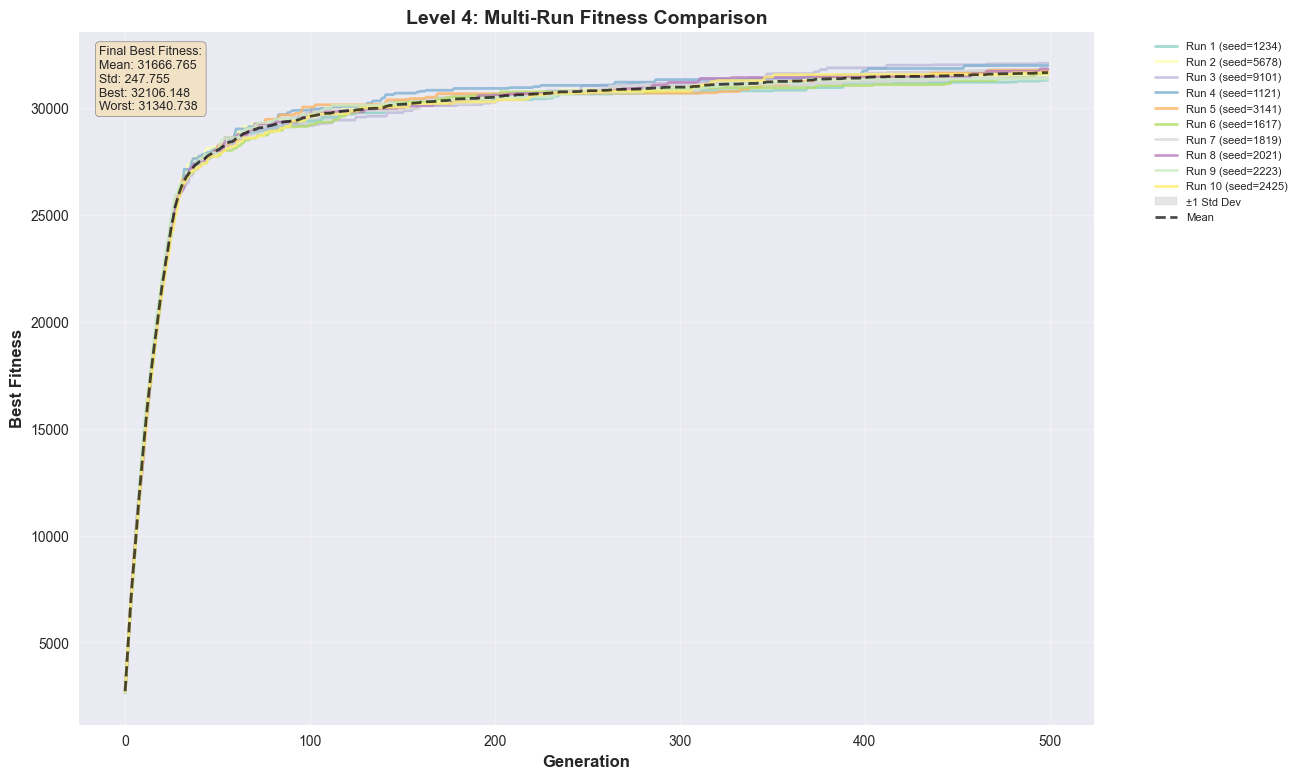

📈 Creating performance distribution analysis...


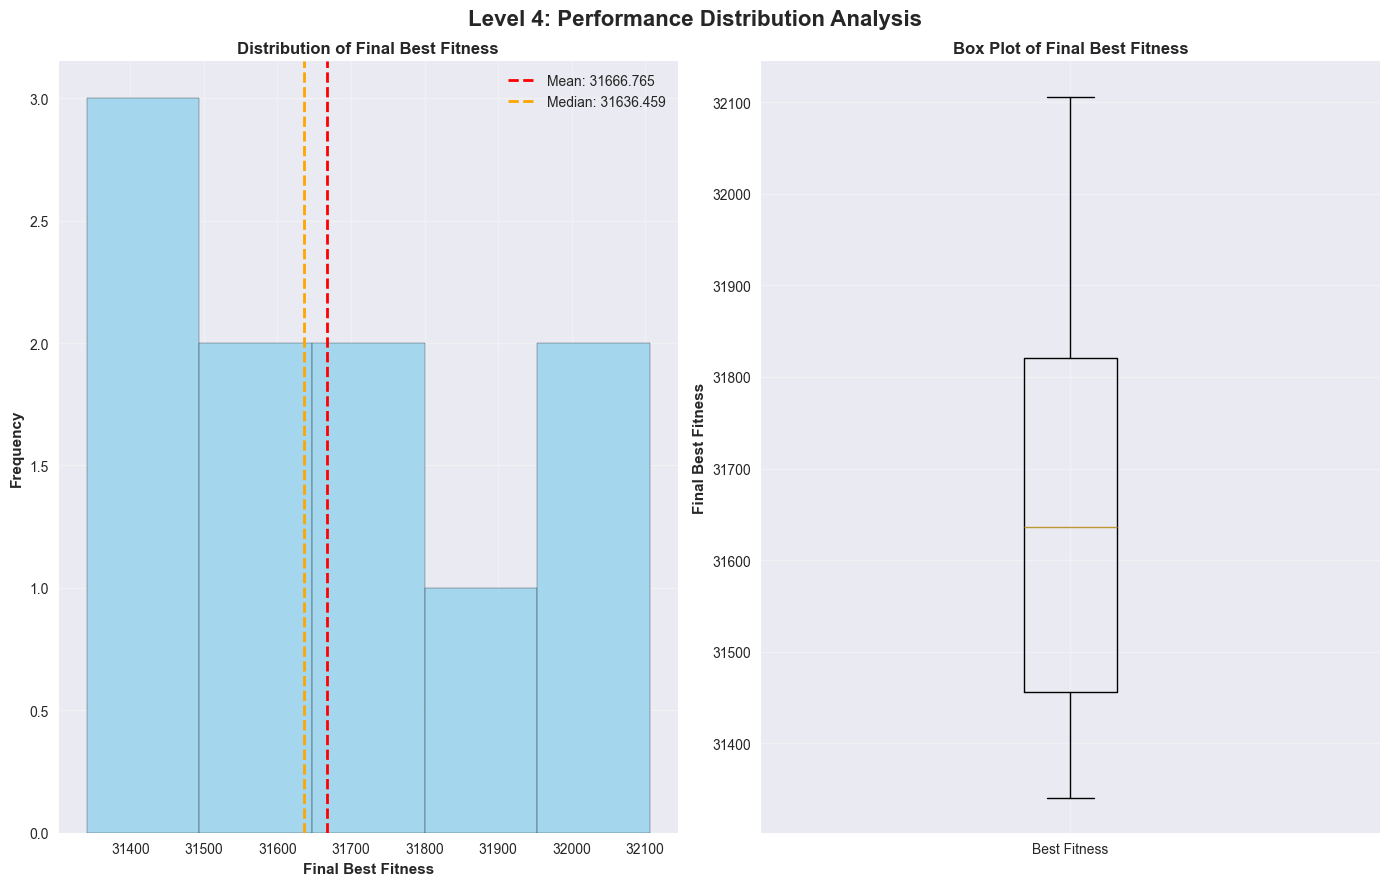


📋 Performance Summary Table (cached computation):
               Run Final Best Final Mean Total Improvement Improvement Rate  Convergence Generation Final Diversity
 Run 1 (seed=1234) 31340.7383 21240.6172        28718.5920        57.437184                      37      13515.4365
 Run 2 (seed=5678) 31549.9785 18635.3730        28778.0981        57.556196                      31      14534.9170
 Run 3 (seed=9101) 32106.1484 20757.5410        29375.9456        58.751891                      35      14118.9033
 Run 4 (seed=1121) 31998.4648 19028.0566        29192.6084        58.385217                      32      14526.0596
 Run 5 (seed=3141) 31769.2344 19185.9629        28923.6533        57.847307                      31      14333.4531
 Run 6 (seed=1617) 31621.3672 18973.5020        28919.4604        57.838921                      34      14424.3496
 Run 7 (seed=1819) 31424.9746 18647.7363        28718.1218        57.436244                      38      14419.9648
 Run 8 (seed=2021) 31

In [9]:
print("🚀 LEVEL 4 MULTI-RUN ANALYSIS DEMO")
print("=" * 45)

print("✅ NEW WAY - Level 4 Stateful Multi-Run Classes:")

# Initialize Level 4 multi-run analyzers ONCE
comparator = EngineComparator(results, config=level4_config)
fda_analyzer = FunctionalDataAnalyzer(results, config=level4_config)

print(f"   ✅ EngineComparator initialized with {comparator.n_runs} runs")
print(f"   ✅ FunctionalDataAnalyzer initialized for advanced FDA")
print(f"   📊 Run names: {', '.join(comparator.run_names[:3])}...")

print("\n📊 Multi-Run Comparison with Statistics:")

# Comprehensive comparison dashboard
comparison_fig = comparator.create_comparison_dashboard(
    kpi='best_fitness',
    confidence_intervals=True,
    show_statistics=True,
    title="Level 4: Multi-Run Fitness Comparison"
)
plt.show()

# Performance distribution analysis
print("📈 Creating performance distribution analysis...")
distribution_fig = comparator.create_performance_distribution(
    kpi='best_fitness',
    title="Level 4: Performance Distribution Analysis"
)
plt.show()

# Get comprehensive performance summary (cached)
print("\n📋 Performance Summary Table (cached computation):")
summary_table = comparator.get_performance_summary()
print(summary_table.to_string(index=False))

## 9. Advanced Statistical Analysis

Demonstrate Level 4 cached statistical computations.

In [10]:
print("📊 Advanced Statistical Analysis with Level 4 Caching")
print("-" * 55)

# Get detailed statistical summary (cached computation)
stats = comparator.get_statistical_summary('best_fitness')

print("🔢 Statistical Summary (automatically cached):")
for metric, value in stats.items():
    if 'percent' in metric or 'rate' in metric:
        print(f"   {metric.replace('_', ' ').title()}: {value:.1f}%")
    else:
        print(f"   {metric.replace('_', ' ').title()}: {value:.4f}")

# Demonstrate cached final values retrieval
print("\n⚡ Cached Data Retrieval Demo:")

# First call - computes and caches
start_time = time.time()
final_values_1 = comparator.get_final_values('best_fitness')
first_retrieval = time.time() - start_time

# Second call - cache hit
start_time = time.time()
final_values_2 = comparator.get_final_values('best_fitness')
second_retrieval = time.time() - start_time

print(f"   First final values retrieval: {first_retrieval:.6f} seconds")
print(f"   Second final values retrieval: {second_retrieval:.6f} seconds")
print(f"   Cache verification: {final_values_1 == final_values_2}")

# Show cache status
print(f"\n💾 Current Cache Status:")
print(f"   EngineComparator main cache: {len(comparator._cache)} items")
print(f"   Final values cache: {len(comparator._final_values_cache)} KPIs")
print(f"   Performance summary cached: {comparator._performance_summary is not None}")

📊 Advanced Statistical Analysis with Level 4 Caching
-------------------------------------------------------
🔢 Statistical Summary (automatically cached):
   Mean Final: 31666.7650
   Std Final: 247.7548
   Best Run: 32106.1484
   Worst Run: 31340.7383
   Median Final: 31636.4590
   Cv Percent: 0.8%
   Mean Improvement: 28947.5504
   Std Improvement: 219.9330
   Success Rate: 100.0%

⚡ Cached Data Retrieval Demo:
   First final values retrieval: 0.000023 seconds
   Second final values retrieval: 0.000018 seconds
   Cache verification: True

💾 Current Cache Status:
   EngineComparator main cache: 2 items
   Final values cache: 1 KPIs
   Performance summary cached: True


## 10. 🔬 Level 4 Functional Data Analysis

**Advanced FDA with Multiple Basis Functions and Caching**

🔬 LEVEL 4 FUNCTIONAL DATA ANALYSIS DEMO
🎯 Advanced FDA with Intelligent Caching:

📈 Testing Fourier Basis with Gaussian Smoothing:


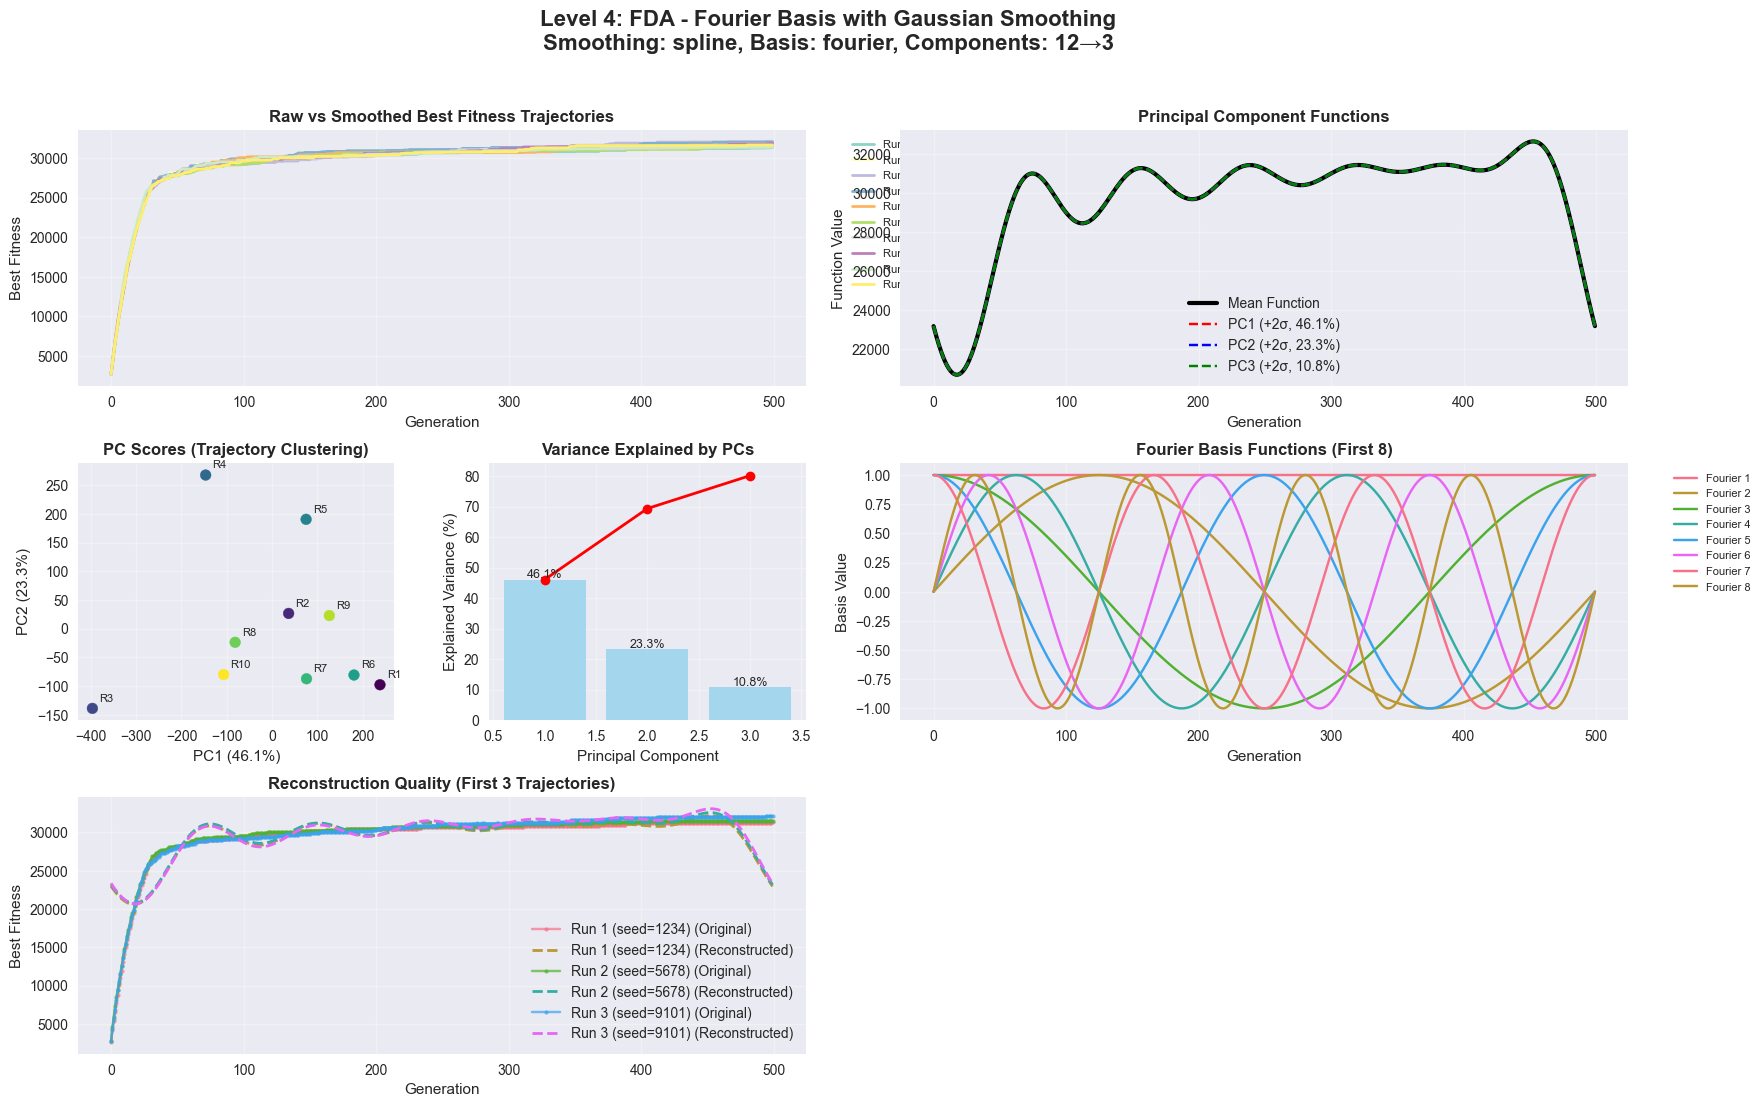

📊 Fourier fPCA Results (automatically cached):
   PC1 explains 46.1% of variance
   PC2 explains 23.3% of variance
   PC3 explains 10.8% of variance
   Total explained: 80.1%

🎯 Testing Gaussian RBF Basis with Spline Smoothing:


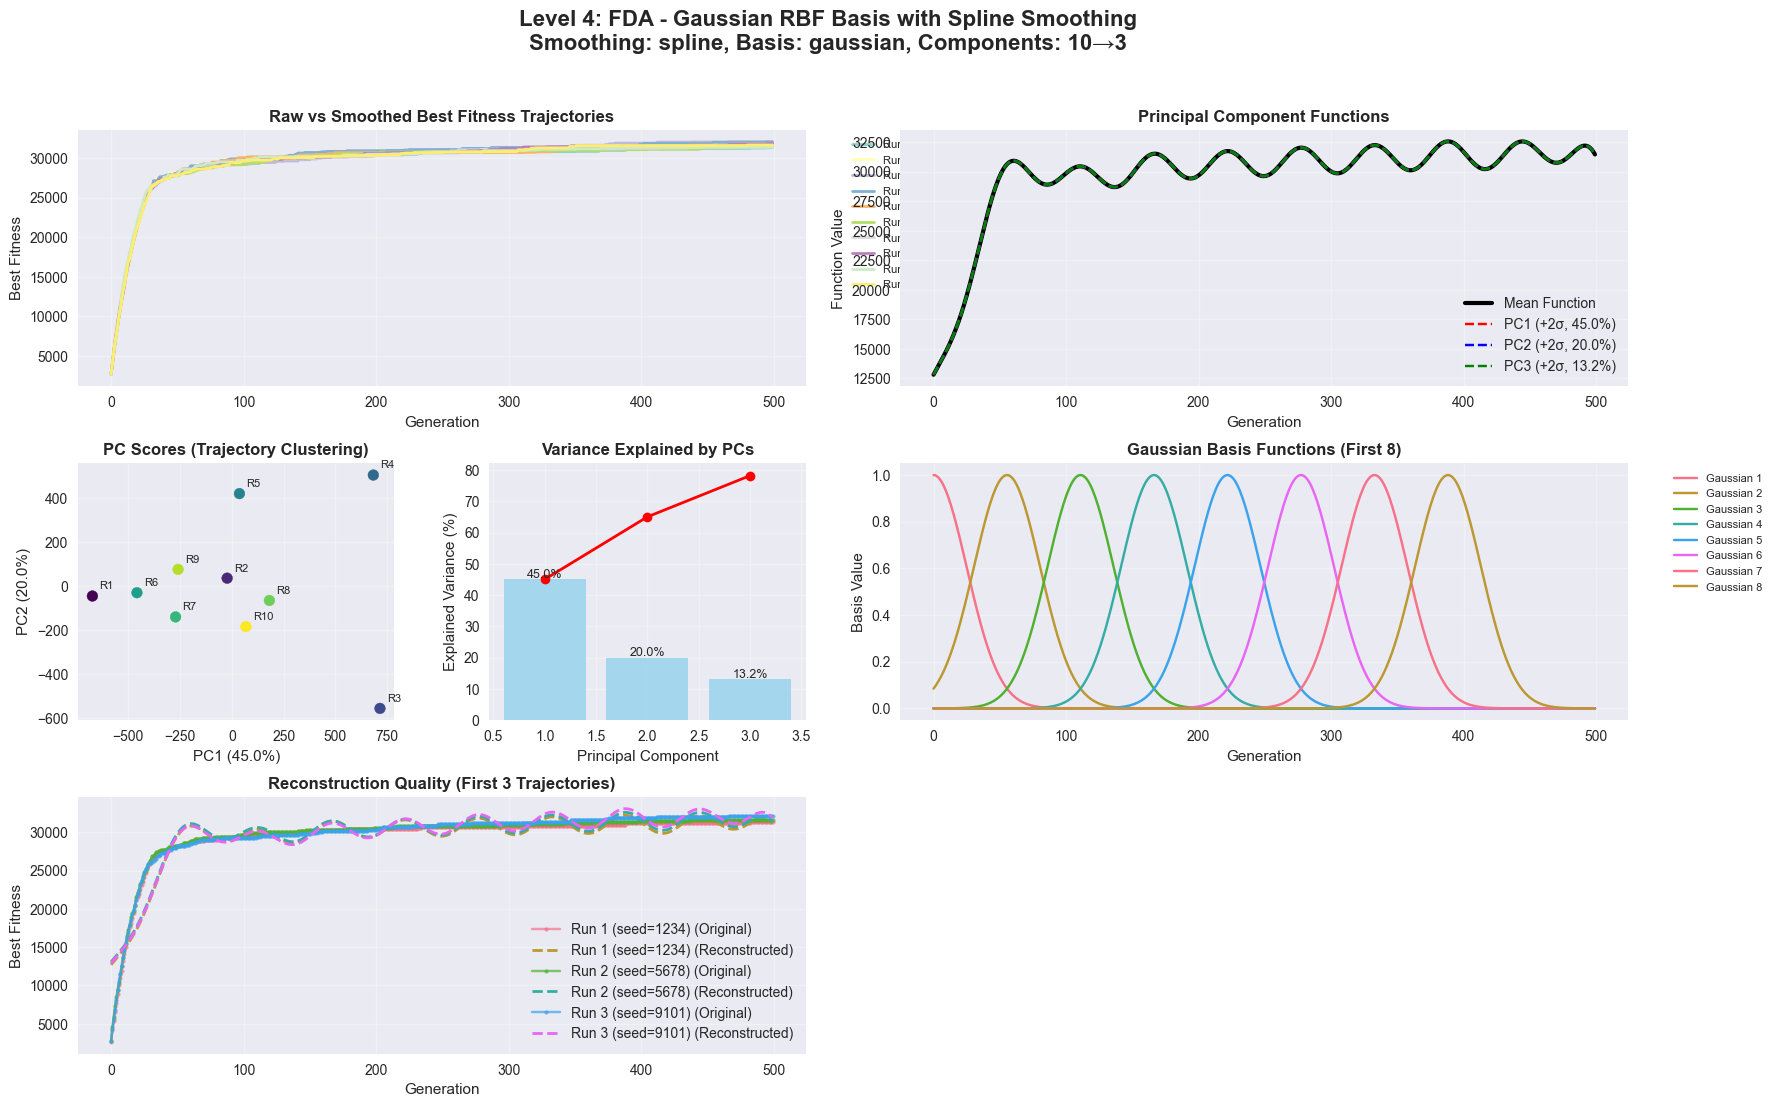

📊 Gaussian RBF fPCA Results:
   PC1 explains 45.0% of variance
   PC2 explains 20.0% of variance
   Total explained: 78.2%

💾 FDA Cache Status:
   Main FDA cache: 2 items
   Smoothed data cache: 1 configurations
   fPCA results cache: 2 configurations
   Basis functions cache: 2 basis sets


In [11]:
print("🔬 LEVEL 4 FUNCTIONAL DATA ANALYSIS DEMO")
print("=" * 45)

print("🎯 Advanced FDA with Intelligent Caching:")

# Test different smoothing methods and basis functions
print("\n📈 Testing Fourier Basis with Gaussian Smoothing:")
fda_fig1, fpca_results1 = fda_analyzer.create_functional_analysis_dashboard(
    kpi='best_fitness',
    smoothing_method='spline', # possible: 'gaussian', 'polynomial', 'spline', 'savgol'
    basis_type='fourier', # possible: 'fourier', 'bspline', 'gaussian'
    n_basis=12,
    n_components=3,
    title="Level 4: FDA - Fourier Basis with Gaussian Smoothing"
)
plt.show()

print(f"📊 Fourier fPCA Results (automatically cached):")
print(f"   PC1 explains {fpca_results1['explained_variance_ratio'][0]*100:.1f}% of variance")
print(f"   PC2 explains {fpca_results1['explained_variance_ratio'][1]*100:.1f}% of variance")
print(f"   PC3 explains {fpca_results1['explained_variance_ratio'][2]*100:.1f}% of variance")
print(f"   Total explained: {sum(fpca_results1['explained_variance_ratio'])*100:.1f}%")

print("\n🎯 Testing Gaussian RBF Basis with Spline Smoothing:")
fda_fig2, fpca_results2 = fda_analyzer.create_functional_analysis_dashboard(
    kpi='best_fitness',
    smoothing_method='spline', # possible: 'gaussian', 'polynomial', 'spline', 'savgol'
    basis_type='gaussian', # possible: 'fourier', 'bspline', 'gaussian'
    n_basis=10,
    n_components=3,
    title="Level 4: FDA - Gaussian RBF Basis with Spline Smoothing"
)
plt.show()

print(f"📊 Gaussian RBF fPCA Results:")
print(f"   PC1 explains {fpca_results2['explained_variance_ratio'][0]*100:.1f}% of variance")
print(f"   PC2 explains {fpca_results2['explained_variance_ratio'][1]*100:.1f}% of variance")
print(f"   Total explained: {sum(fpca_results2['explained_variance_ratio'])*100:.1f}%")

# Demonstrate caching efficiency
print(f"\n💾 FDA Cache Status:")
print(f"   Main FDA cache: {len(fda_analyzer._cache)} items")
print(f"   Smoothed data cache: {len(fda_analyzer._smoothed_data_cache)} configurations")
print(f"   fPCA results cache: {len(fda_analyzer._fpca_results_cache)} configurations")
print(f"   Basis functions cache: {len(fda_analyzer._basis_cache)} basis sets")

## 11. Advanced FDA Operations

Demonstrate individual FDA operations with caching benefits.

In [12]:
print("🔬 Advanced FDA Operations Demo")
print("-" * 35)

# Test trajectory smoothing with different methods
print("📈 Testing trajectory smoothing methods:")

smoothing_methods = ['gaussian', 'polynomial', 'spline']
for method in smoothing_methods:
    print(f"\n   Testing {method} smoothing...")
    start_time = time.time()
    smoothed_data = fda_analyzer.smooth_trajectories(
        kpi='best_fitness',
        method=method,
        sigma=2.0,
        polynomial_degree=3
    )
    smoothing_time = time.time() - start_time
    print(f"     ✅ {method} smoothing: {smoothing_time:.4f} seconds")
    print(f"     📊 Smoothed {len(smoothed_data)} trajectories")

# Test basis function creation
print("\n🎯 Testing basis function creation:")

basis_types = ['fourier', 'polynomial', 'gaussian']
test_generations = np.arange(engine_params.num_generations)

for basis_type in basis_types:
    print(f"\n   Creating {basis_type} basis functions...")
    start_time = time.time()
    basis_matrix = fda_analyzer.create_basis_functions(
        test_generations,
        basis_type=basis_type,
        n_basis=10
    )
    basis_time = time.time() - start_time
    print(f"     ✅ {basis_type} basis: {basis_time:.4f} seconds")
    print(f"     📐 Matrix shape: {basis_matrix.shape}")

# Perform standalone fPCA
print("\n🔬 Performing standalone fPCA:")
fpca_standalone = fda_analyzer.perform_functional_pca(
    kpi='best_fitness',
    smoothing_method='gaussian',
    basis_type='fourier',
    n_basis=15,
    n_components=4
)

print(f"   ✅ fPCA complete with 4 components")
print(f"   📊 PC scores shape: {fpca_standalone['pc_scores'].shape}")
print(f"   📈 Explained variance: {fpca_standalone['explained_variance_ratio']*100}")
print(f"   🎯 Total variance explained: {sum(fpca_standalone['explained_variance_ratio'])*100:.1f}%")

print(f"\n💾 Final Cache Status:")
print(f"   Total FDA cache items: {len(fda_analyzer._cache)}")
print(f"   Unique smoothing configurations: {len(fda_analyzer._smoothed_data_cache)}")
print(f"   Unique fPCA configurations: {len(fda_analyzer._fpca_results_cache)}")

🔬 Advanced FDA Operations Demo
-----------------------------------
📈 Testing trajectory smoothing methods:

   Testing gaussian smoothing...
     ✅ gaussian smoothing: 0.0062 seconds
     📊 Smoothed 10 trajectories

   Testing polynomial smoothing...
     ✅ polynomial smoothing: 0.0011 seconds
     📊 Smoothed 10 trajectories

   Testing spline smoothing...
     ✅ spline smoothing: 0.0000 seconds
     📊 Smoothed 10 trajectories

🎯 Testing basis function creation:

   Creating fourier basis functions...
     ✅ fourier basis: 0.0001 seconds
     📐 Matrix shape: (500, 10)

   Creating polynomial basis functions...
     ✅ polynomial basis: 0.0001 seconds
     📐 Matrix shape: (500, 10)

   Creating gaussian basis functions...
     ✅ gaussian basis: 0.0001 seconds
     📐 Matrix shape: (500, 10)

🔬 Performing standalone fPCA:
   ✅ fPCA complete with 4 components
   📊 PC scores shape: (10, 4)
   📈 Explained variance: [45.85342984 23.11477539 10.78253332  8.44378778]
   🎯 Total variance explaine

## 12. Configuration Comparison Demo

Show how different `VisualizationConfig` settings affect output.

🎨 Configuration Comparison Demo
-----------------------------------
📊 Comparing different visualization configurations:

🎯 Original Configuration:
   Style: seaborn-v0_8
   Palette: husl
   Figure size: (14, 9)


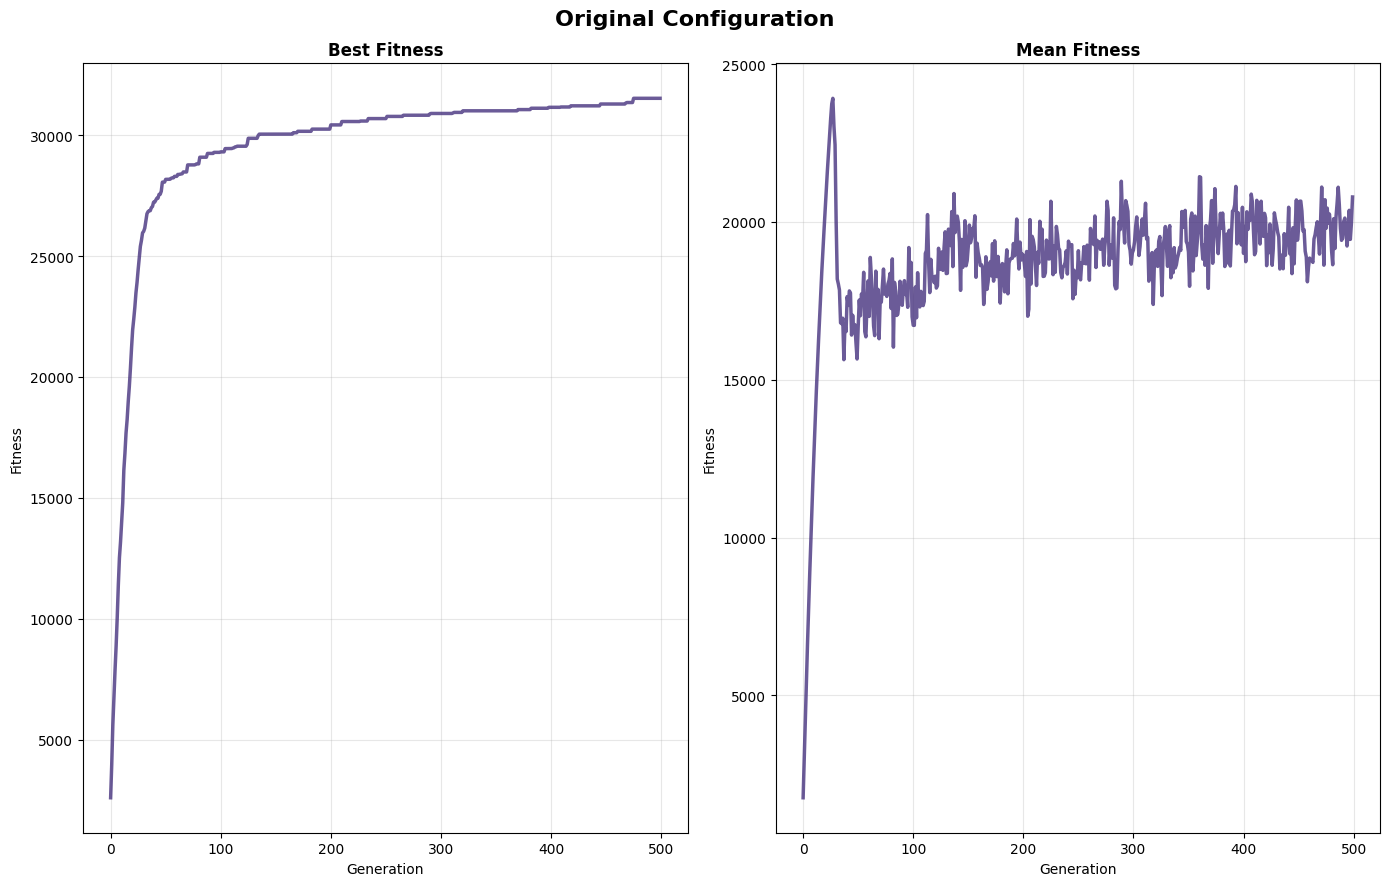


🎨 Alternative Configuration:
   Style: default
   Palette: viridis
   Figure size: (12, 8)


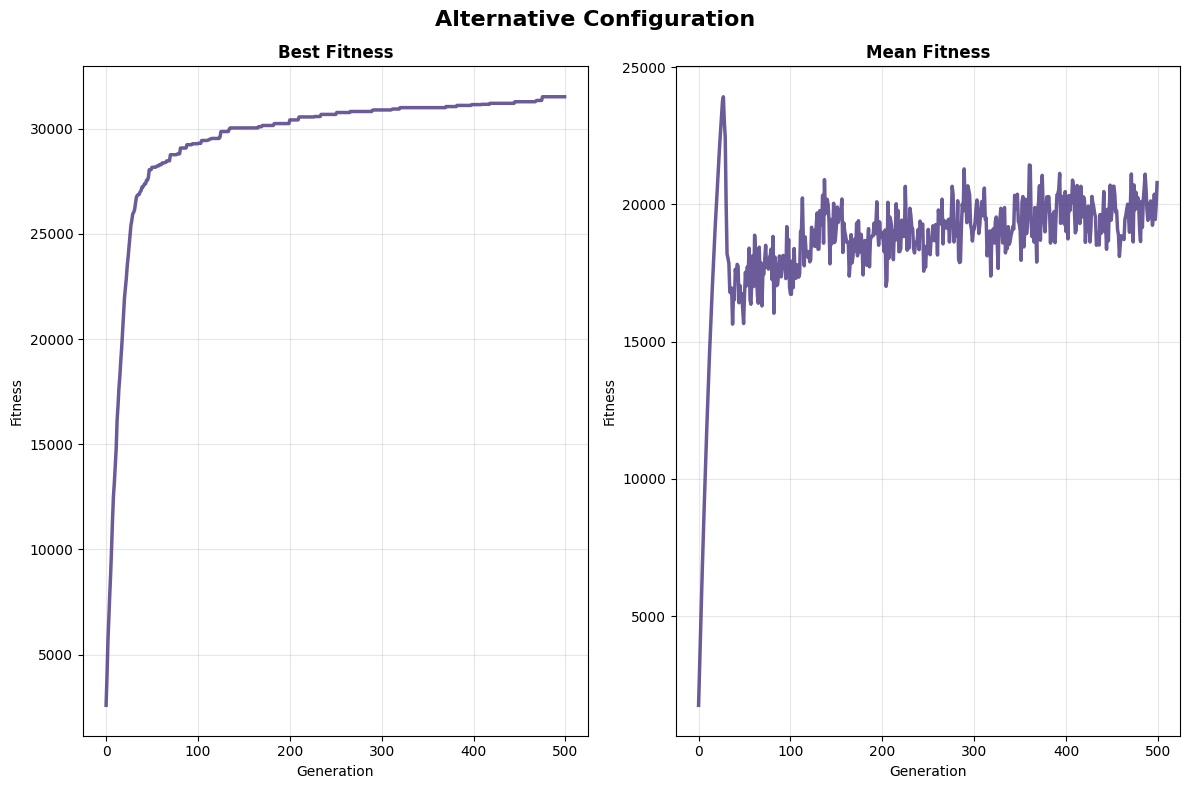


✅ Configuration-driven styling demonstrated!
   Each visualizer maintains its own styling consistently
   Easy to switch between different visual themes


In [13]:
print("🎨 Configuration Comparison Demo")
print("-" * 35)

print("📊 Comparing different visualization configurations:")

# Create visualizer with alternative configuration
alt_viz = EvolutionVisualizer(history, config=alternative_config)

print(f"\n🎯 Original Configuration:")
print(f"   Style: {level4_config.style}")
print(f"   Palette: {level4_config.color_palette}")
print(f"   Figure size: {level4_config.figsize}")

original_dashboard = universal_viz.create_dashboard(
    kpis=['best_fitness', 'mean_fitness'],
    title="Original Configuration"
)
plt.show()

print(f"\n🎨 Alternative Configuration:")
print(f"   Style: {alternative_config.style}")
print(f"   Palette: {alternative_config.color_palette}")
print(f"   Figure size: {alternative_config.figsize}")

alt_dashboard = alt_viz.create_dashboard(
    kpis=['best_fitness', 'mean_fitness'],
    title="Alternative Configuration"
)
plt.show()

print("\n✅ Configuration-driven styling demonstrated!")
print("   Each visualizer maintains its own styling consistently")
print("   Easy to switch between different visual themes")

## 13. Cache Management Demo

Demonstrate Level 4 intelligent cache management capabilities.

In [14]:
print("💾 LEVEL 4 CACHE MANAGEMENT DEMO")
print("=" * 40)

# Show comprehensive cache status before clearing
print("📊 Current Cache Status Across All Level 4 Components:")
print(f"   Universal Visualizer: {len(universal_viz._cache)} items")
print(f"   GA Visualizer: {len(ga_viz._cache)} items")
print(f"   Alternative Visualizer: {len(alt_viz._cache)} items")
print(f"   Engine Comparator: {len(comparator._cache)} items")
print(f"   FDA Analyzer main: {len(fda_analyzer._cache)} items")
print(f"   FDA smoothed data: {len(fda_analyzer._smoothed_data_cache)} configs")
print(f"   FDA fPCA results: {len(fda_analyzer._fpca_results_cache)} configs")
print(f"   FDA basis functions: {len(fda_analyzer._basis_cache)} sets")

total_items = (len(universal_viz._cache) + len(ga_viz._cache) + len(alt_viz._cache) + 
               len(comparator._cache) + len(fda_analyzer._cache) + 
               len(fda_analyzer._smoothed_data_cache) + 
               len(fda_analyzer._fpca_results_cache) + 
               len(fda_analyzer._basis_cache))
print(f"\n   📊 Total cached items across all Level 4 components: {total_items}")

# Demonstrate selective cache clearing
print("\n🧹 Selective Cache Clearing Demo:")

# Clear only FDA caches
print("   Clearing FDA analyzer caches...")
fda_analyzer.clear_cache()
print(f"   ✅ FDA caches cleared: {len(fda_analyzer._cache)} + {len(fda_analyzer._smoothed_data_cache)} + {len(fda_analyzer._fpca_results_cache)}")

# Single visualizer cache remains intact
print(f"   ✅ Single visualizer caches intact: {len(universal_viz._cache)} items")

# Demonstrate cache persistence benefits
print("\n⚡ Cache Persistence Demo:")
print("   Creating dashboard from cached data...")
start_time = time.time()
cached_dashboard = universal_viz.create_dashboard(title="From Cache")
cached_time = time.time() - start_time
plt.close()  # Don't show the plot

print(f"   ⚡ Dashboard from cache: {cached_time:.6f} seconds")
print("   ✅ Single visualizers maintain their caches independently")

# Clear all caches
print("\n🧹 Clearing All Level 4 Caches:")
universal_viz.clear_cache()
ga_viz.clear_cache()
alt_viz.clear_cache()
comparator.clear_cache()
fda_analyzer.clear_cache()  # Already cleared, but for completeness

final_total = (len(universal_viz._cache) + len(ga_viz._cache) + len(alt_viz._cache) + 
               len(comparator._cache) + len(fda_analyzer._cache) + 
               len(fda_analyzer._smoothed_data_cache) + 
               len(fda_analyzer._fpca_results_cache) + 
               len(fda_analyzer._basis_cache))

print(f"   ✅ All caches cleared: {final_total} total items remaining")
print("   💡 Ready for fresh computations with clean memory footprint")

print("\n🎯 Cache Management Benefits:")
print("   ✅ Selective clearing for memory management")
print("   ✅ Independent caches per visualizer instance")
print("   ✅ Automatic invalidation when parameters change")
print("   ✅ Significant performance improvements for repeated operations")

💾 LEVEL 4 CACHE MANAGEMENT DEMO
📊 Current Cache Status Across All Level 4 Components:
   Universal Visualizer: 10 items
   GA Visualizer: 8 items
   Alternative Visualizer: 3 items
   Engine Comparator: 2 items
   FDA Analyzer main: 2 items
   FDA smoothed data: 3 configs
   FDA fPCA results: 3 configs
   FDA basis functions: 6 sets

   📊 Total cached items across all Level 4 components: 37

🧹 Selective Cache Clearing Demo:
   Clearing FDA analyzer caches...
   ✅ FDA caches cleared: 0 + 0 + 0
   ✅ Single visualizer caches intact: 10 items

⚡ Cache Persistence Demo:
   Creating dashboard from cached data...
   ⚡ Dashboard from cache: 0.000021 seconds
   ✅ Single visualizers maintain their caches independently

🧹 Clearing All Level 4 Caches:
   ✅ All caches cleared: 0 total items remaining
   💡 Ready for fresh computations with clean memory footprint

🎯 Cache Management Benefits:
   ✅ Selective clearing for memory management
   ✅ Independent caches per visualizer instance
   ✅ Automatic 

## 14. 🎉 Level 4 Architecture Summary

**Professional API Design & Benefits**

In [15]:
print("🎉 LEVEL 4 VISUALIZATION ARCHITECTURE SUMMARY")
print("=" * 55)

print("🏗️  MalthusJAX Architecture Levels:")
print("   Level 1: Core (genome, fitness)")
print("   Level 2: Operators (selection, crossover, mutation)")
print("   Level 3: Engines (complete evolutionary algorithms)")
print("   ➤ Level 4: Visualization (stateful, cached analysis)")

print("\n📚 Level 4 Class Hierarchy:")
print("   AbstractVisualizer")
print("   ├── EvolutionVisualizer (universal single-run)")
print("   └── GeneticAlgorithmVisualizer (GA-specific)")
print("   ")
print("   AbstractMultiRunVisualizer")
print("   ├── EngineComparator (multi-run comparison)")
print("   └── FunctionalDataAnalyzer (FDA & fPCA)")

print("\n✨ Key Design Improvements:")
improvements = [
    "🔧 Stateful Initialization: Initialize once with data",
    "⚡ Intelligent Caching: Expensive computations cached automatically",
    "🎨 Clean API: No repeated data passing to methods", 
    "📐 Configuration-Driven: Centralized styling via VisualizationConfig",
    "🛡️  Type Safety: Specialized classes for different analysis types",
    "🧠 Memory Efficient: Smart cache management with clear() methods",
    "🔄 Parameter-Aware: Automatic cache invalidation when settings change",
    "📊 Separation of Concerns: Single vs multi-run specialized classes"
]

for improvement in improvements:
    print(f"   {improvement}")

print("\n🆚 API Comparison:")
print("-" * 20)
print("❌ OLD API (Static Methods):")
print("   fig1 = EvolutionVisualizer.create_kpi_dashboard(history, title='A')")
print("   fig2 = EvolutionVisualizer.create_kpi_dashboard(history, title='B')  # Recomputes!")
print("   fig3 = EngineComparator.compare_engines(results, 'best_fitness')     # Recomputes!")
print("")
print("✅ NEW API (Stateful Classes):")
print("   viz = EvolutionVisualizer(history, config)")
print("   fig1 = viz.create_dashboard(title='A')  # Computes & caches")
print("   fig2 = viz.create_dashboard(title='B')  # Cache hit!")
print("   ")
print("   comparator = EngineComparator(results, config)")
print("   fig3 = comparator.create_comparison_dashboard()  # Computes & caches")
print("   stats = comparator.get_statistical_summary()     # Cache hit!")

print("\n🎯 Professional Benefits:")
benefits = [
    "📊 Cleaner notebooks with less repetitive code",
    "⚡ Faster analysis with intelligent caching",
    "🛡️  Better error handling and type safety",
    "🎨 Consistent styling across all visualizations", 
    "🔧 Easier maintenance and extensibility",
    "📐 True object-oriented design following MalthusJAX patterns",
    "🔬 Advanced FDA capabilities with user-selectable basis functions",
    "📈 Production-ready for large-scale evolutionary experiments"
]

for benefit in benefits:
    print(f"   {benefit}")

print("\n🔮 Future Enhancements Enabled:")
future_features = [
    "📊 Export capabilities for publications (PDF/SVG/EPS)",
    "🎨 Interactive visualizations with plotly integration",
    "📐 Custom visualization plugins via inheritance",
    "🔄 Real-time visualization updates for live experiments",
    "💾 Persistent cache for large-scale experiment campaigns",
    "🌐 Web-based visualization dashboards",
    "📊 Automated report generation",
    "🔬 Integration with experiment tracking systems"
]

for feature in future_features:
    print(f"   {feature}")

print("\n" + "=" * 55)
print("🎉 LEVEL 4 VISUALIZATION ARCHITECTURE COMPLETE!")
print("   Ready for production-scale evolutionary algorithm analysis!")
print("   Professional, stateful, cached visualization framework!")
print("=" * 55)

🎉 LEVEL 4 VISUALIZATION ARCHITECTURE SUMMARY
🏗️  MalthusJAX Architecture Levels:
   Level 1: Core (genome, fitness)
   Level 2: Operators (selection, crossover, mutation)
   Level 3: Engines (complete evolutionary algorithms)
   ➤ Level 4: Visualization (stateful, cached analysis)

📚 Level 4 Class Hierarchy:
   AbstractVisualizer
   ├── EvolutionVisualizer (universal single-run)
   └── GeneticAlgorithmVisualizer (GA-specific)
   
   AbstractMultiRunVisualizer
   ├── EngineComparator (multi-run comparison)
   └── FunctionalDataAnalyzer (FDA & fPCA)

✨ Key Design Improvements:
   🔧 Stateful Initialization: Initialize once with data
   ⚡ Intelligent Caching: Expensive computations cached automatically
   🎨 Clean API: No repeated data passing to methods
   📐 Configuration-Driven: Centralized styling via VisualizationConfig
   🛡️  Type Safety: Specialized classes for different analysis types
   🧠 Memory Efficient: Smart cache management with clear() methods
   🔄 Parameter-Aware: Automatic c